In [1]:
# Author Davide Aloi
# Scripts for the analyses of the EEG data (active task) collected at the Wellington Hospital - Aloi Davide PhD UoB

import numpy as np
import mne
import os
import glob 
import matplotlib.pyplot as plt
from preprocessing.preprocess import preprocess 
import autoreject
from autoreject import Ransac
from time import time, ctime

mne.set_log_level("WARNING")

# Folders to the EEG active task data
output_folder = 'D:\\Raindrop_eeg_analysis\\p01\\'
sessions = ['D:\\Raindrop_data\\p01\\p01_w01\\eeg_baseline\\active_task\\', # baseline w 1
            'D:\\Raindrop_data\\p01\\p01_w02\\day04_eeg\\active_task\\', # post w 2
            'D:\\Raindrop_data\\p01\\p01_w03\\eeg_baseline\\active_task\\', # baseline w 3
            'D:\\Raindrop_data\\p01\\p01_w04\\day04_eeg\\active_task\\', # post w 4
            'D:\\Raindrop_data\\p01\\p01_w05\\eeg_baseline\\active_task\\', # baseline w5
            'D:\\Raindrop_data\\p01\\p01_w06\\day04_eeg\\active_task\\'] # post w6

sessions = ['D:\\Raindrop_data\\p01\\p01_w01\\eeg_baseline\\active_task\\']
# Paths to .mff files
sessions_raw = []
for n, session in enumerate(sessions):
    sessions_raw.append(glob.glob(session + '\*.mff')[0])

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


D:\Raindrop_data\p01\p01_w01\eeg_baseline\active_task\p01_w01_active_20220422_154518.mff
Preprocessing session: p01_w01
Results and plots will be saved in folder: D:\Raindrop_eeg_analysis\p01\
Montage: GSN-HydroCel-128
72 events found
Event IDs: [1 2]
Filtering data (1 - 100Hz). Tue Jul  5 14:39:38 2022
Filtering Done. Tue Jul  5 14:39:47 2022
Setting reference: average
Epoching data: -1s - 3s.
Detecting bad channels with Ransac. Tue Jul  5 14:39:48 2022


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   19.4s remaining:   58.5s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   19.5s remaining:   32.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   20.0s remaining:   20.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   20.1s remaining:   12.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   20.1s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   20.5s finished


Bad channels detected: 38
['E4', 'E5', 'E6', 'E7', 'E10', 'E11', 'E12', 'E18', 'E19', 'E29', 'E33', 'E40', 'E42', 'E47', 'E51', 'E52', 'E59', 'E66', 'E70', 'E73', 'E75', 'E82', 'E92', 'E93', 'E95', 'E98', 'E101', 'E102', 'E103', 'E104', 'E108', 'E109', 'E111', 'E112', 'E114', 'E116', 'E117', 'E122']
Bad epochs detection (autorject). Tue Jul  5 14:40:12 2022
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=38
Epochs rejected: 21
Fitting ICA. Tue Jul  5 14:42:38 2022
Completed. Tue Jul  5 14:43:37 2022
Automatic ICA labelling (mne_icalabel).  Tue Jul  5 14:43:37 2022


c:\Users\davide\miniconda3\envs\neuroimg\lib\site-packages\mne_icalabel\iclabel\utils.py:139: RuntimeWarning: divide by zero encountered in log
  g = np.square(d) * (np.log(d) - 1)  # % Green's function.
c:\Users\davide\miniconda3\envs\neuroimg\lib\site-packages\mne_icalabel\iclabel\utils.py:139: RuntimeWarning: invalid value encountered in multiply
  g = np.square(d) * (np.log(d) - 1)  # % Green's function.


{'y_pred_proba': array([0.9930228 , 0.9992537 , 0.99990195, 0.991275  , 0.99468684,
       0.9940691 , 0.9977995 , 0.96776575, 0.99297035, 0.60535645,
       0.72387856, 0.40757716, 0.46023703, 0.9916775 , 0.4327931 ,
       0.43824965, 0.8073516 , 0.52955735, 0.9173954 , 0.3312965 ,
       0.5983705 , 0.4206891 , 0.3935048 , 0.90533435, 0.75973785,
       0.60705054, 0.86778736, 0.7446122 , 0.9786597 , 0.46845824],
      dtype=float32), 'labels': ['line noise', 'line noise', 'line noise', 'line noise', 'line noise', 'line noise', 'line noise', 'line noise', 'line noise', 'eye blink', 'line noise', 'brain', 'other', 'eye blink', 'brain', 'muscle artifact', 'heart beat', 'brain', 'line noise', 'line noise', 'other', 'line noise', 'muscle artifact', 'other', 'other', 'muscle artifact', 'line noise', 'line noise', 'other', 'muscle artifact']}
Excluding these ICA components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 18, 19, 21, 22, 25, 26, 27, 29]
Applying ICA
Applying autoreject afte

c:\Users\davide\miniconda3\envs\neuroimg\lib\site-packages\autoreject\utils.py:66: UserWarning: 38 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(






Estimated consensus=0.50 and n_interpolate=38


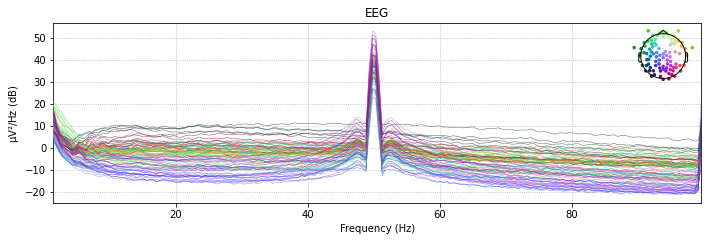

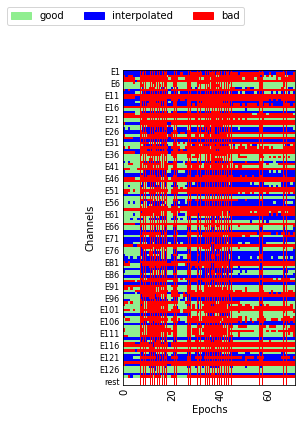

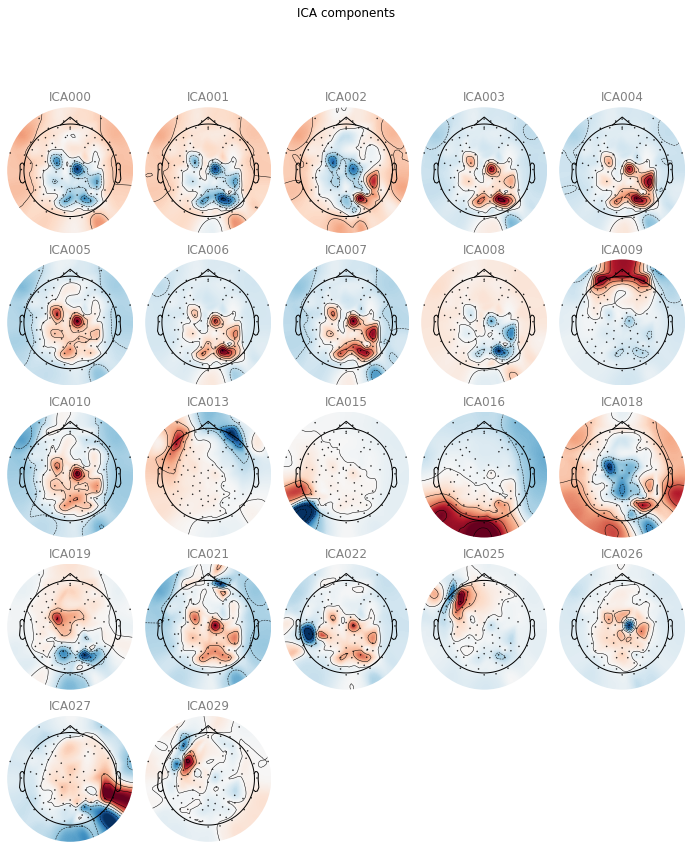

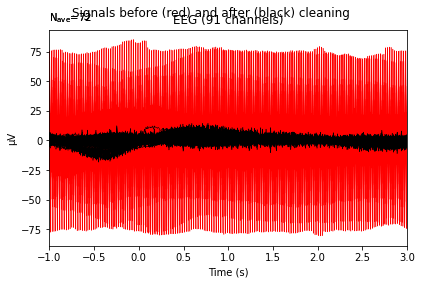

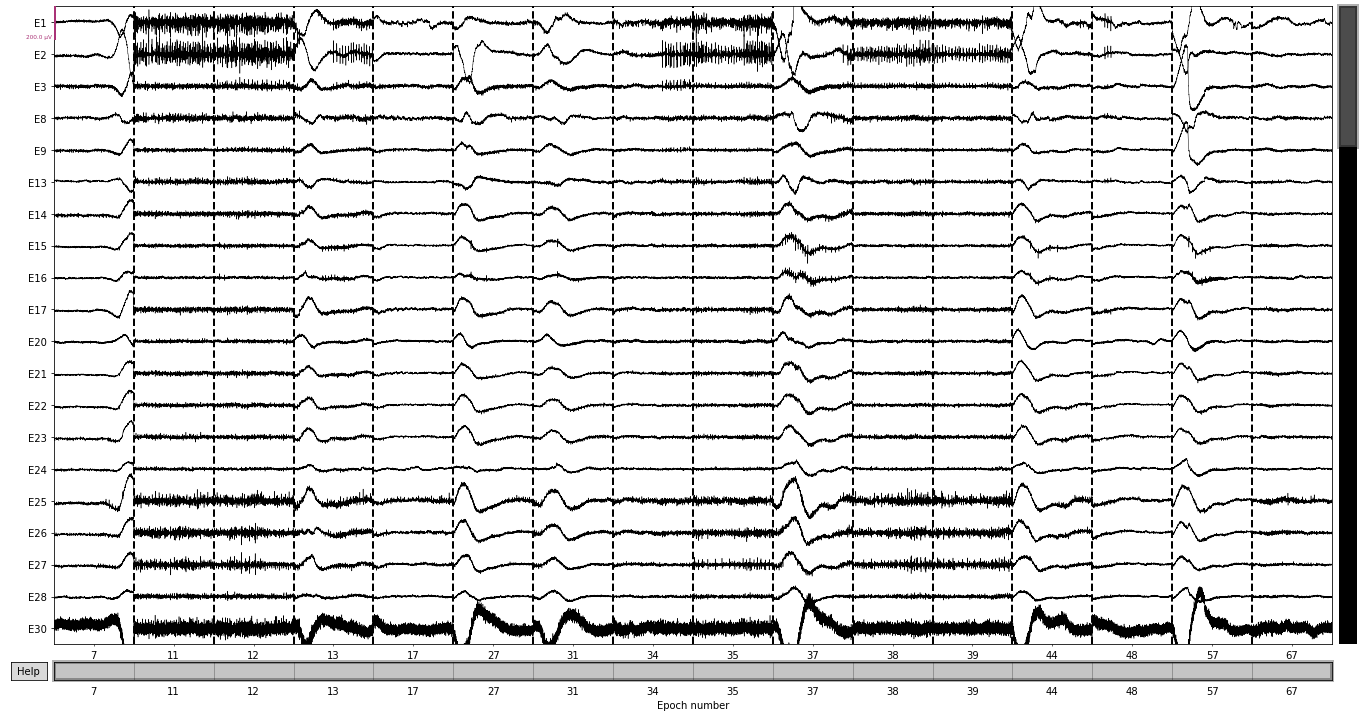

Epochs rejected: 16
Re-refering after ICA.
Applying baseline correction.
Saving epoched data cleaned.


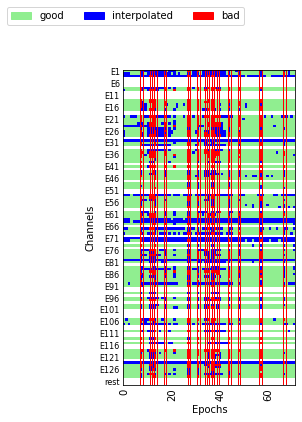

In [2]:
# cleaning all sessions
for session in sessions_raw:
    print(session)
    session_name = session.split('\\')[3]
    raw = mne.io.read_raw_egi(session, preload=True)
    picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=False)
    cleaned_epochs = preprocess(session_name,'D:\\Raindrop_eeg_analysis\\p01\\', raw, 'GSN-HydroCel-128', 'average',
                                'STI 014', picks_eeg, events_id = dict(move=1,relax=2), tmin = -1, tmax = 3,
                                filter = (1,40), baseline = (-0.8,-0.2), review_ica = False,  save = True)